<a href="https://www.kaggle.com/code/yunusemreturkoglu/eda-feature-and-comparisonml-0-87-diabetes?scriptVersionId=138890548" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

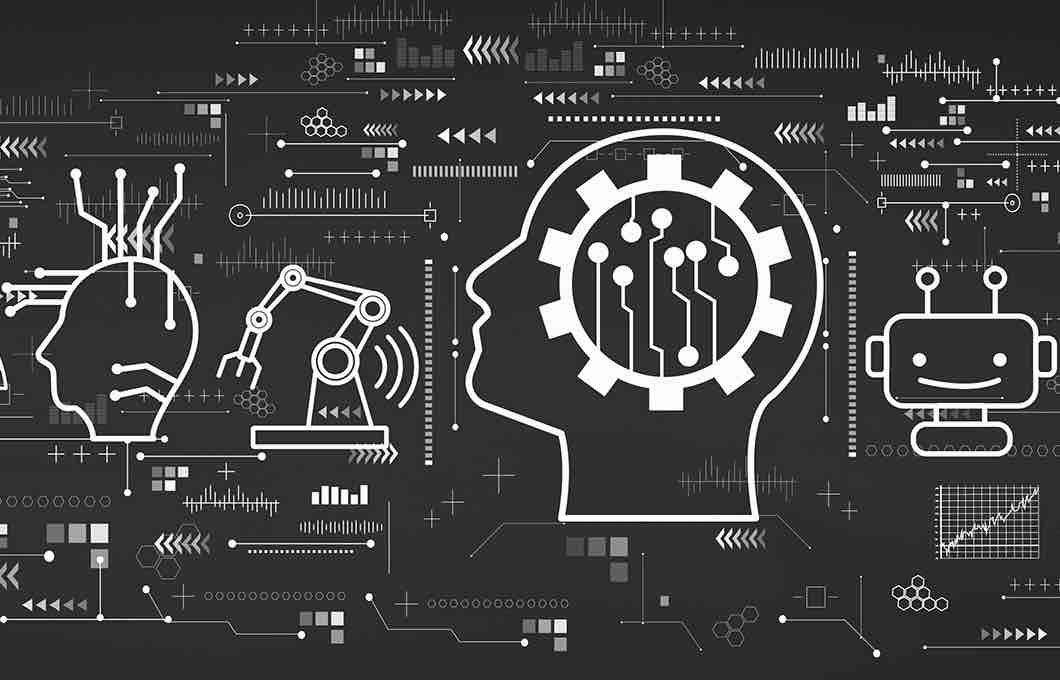

# <span style="font-family:cursive;">WHAT IS MACHINE LEARNING ? </span>
Machine learning is a subset of artificial intelligence that involves training computers to learn patterns and make predictions or decisions based on data, without being explicitly programmed.

In other words, machine learning algorithms use statistical techniques to analyze and learn from data, then apply what they've learned to new data to make predictions or decisions.

There are three main types of machine learning:

   1- Supervised learning, where the computer is trained on labeled data and learns to make predictions or decisions based on that data.

   2- Unsupervised learning, where the computer is given unlabeled data and learns to find patterns or structure in the data without being told what to look for.

   3- Reinforcement learning, where the computer learns through trial and error, by receiving feedback on its actions and adjusting its behavior accordingly.

Machine learning has a wide range of applications, from image and speech recognition to fraud detection and personalized recommendations


# About Dataset
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney
Diseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes,
based on certain diagnostic measurements included in the dataset. Several constraints were placed
on the selection of these instances from a larger database. In particular, all patients here are females
at least 21 years old of Pima Indian heritage.2
From the data set in the (.csv) File We can find several variables, some of them are independent
(several medical predictor variables) and only one target dependent variable (Outcome).


In [1]:
!pip install skompiler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for skompiler: filename=SKompiler-0.7-py3-none-any.whl size=54331 sha256=7d476e626790ebd53785798da5885055e1f42561dbebd38a25315533fd205bde
  Stored in directory: /root/.cache/pip/wheels/ad/a6/45/b63bbda43f70098f004653604c21c64a53fc017998a42133a1
Successfully built skompiler


In [2]:
# Libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from skompiler import skompile
from sklearn.metrics import mean_squared_error
from warnings import filterwarnings
filterwarnings('ignore')


# DATASET

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

diabetes = pd.read_csv("/kaggle/input/diabetes-dataset/diabetes.csv")
df = diabetes.copy()
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [4]:
def check_df(dataframe, head = 5):
    print("############## Shape ##############")
    print(dataframe.shape)
    print("############## Types ##############")
    print(dataframe.dtypes)
    print("############## Head ##############")
    print(dataframe.head(head))
    print("############## Tail ##############")
    print(dataframe.tail(head))
    print("############## NA ##############")
    print(dataframe.isnull().sum())
    print("############## Quantiles ##############")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)


############## Shape ##############
(768, 9)
############## Types ##############
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
############## Head ##############
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.600                     0.627   50        1
1            1       85             66             29        0 26.600                     0.351   31        0
2            8      183             64              0        0 23.300                     0.672   32        1
3            1       89             66             23       94 28.100                     0.167   21      

# DATA PRE-PROCESSING

In [5]:
# Let's make variables's names smaller

df.columns = [col.lower() for col in df.columns]
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


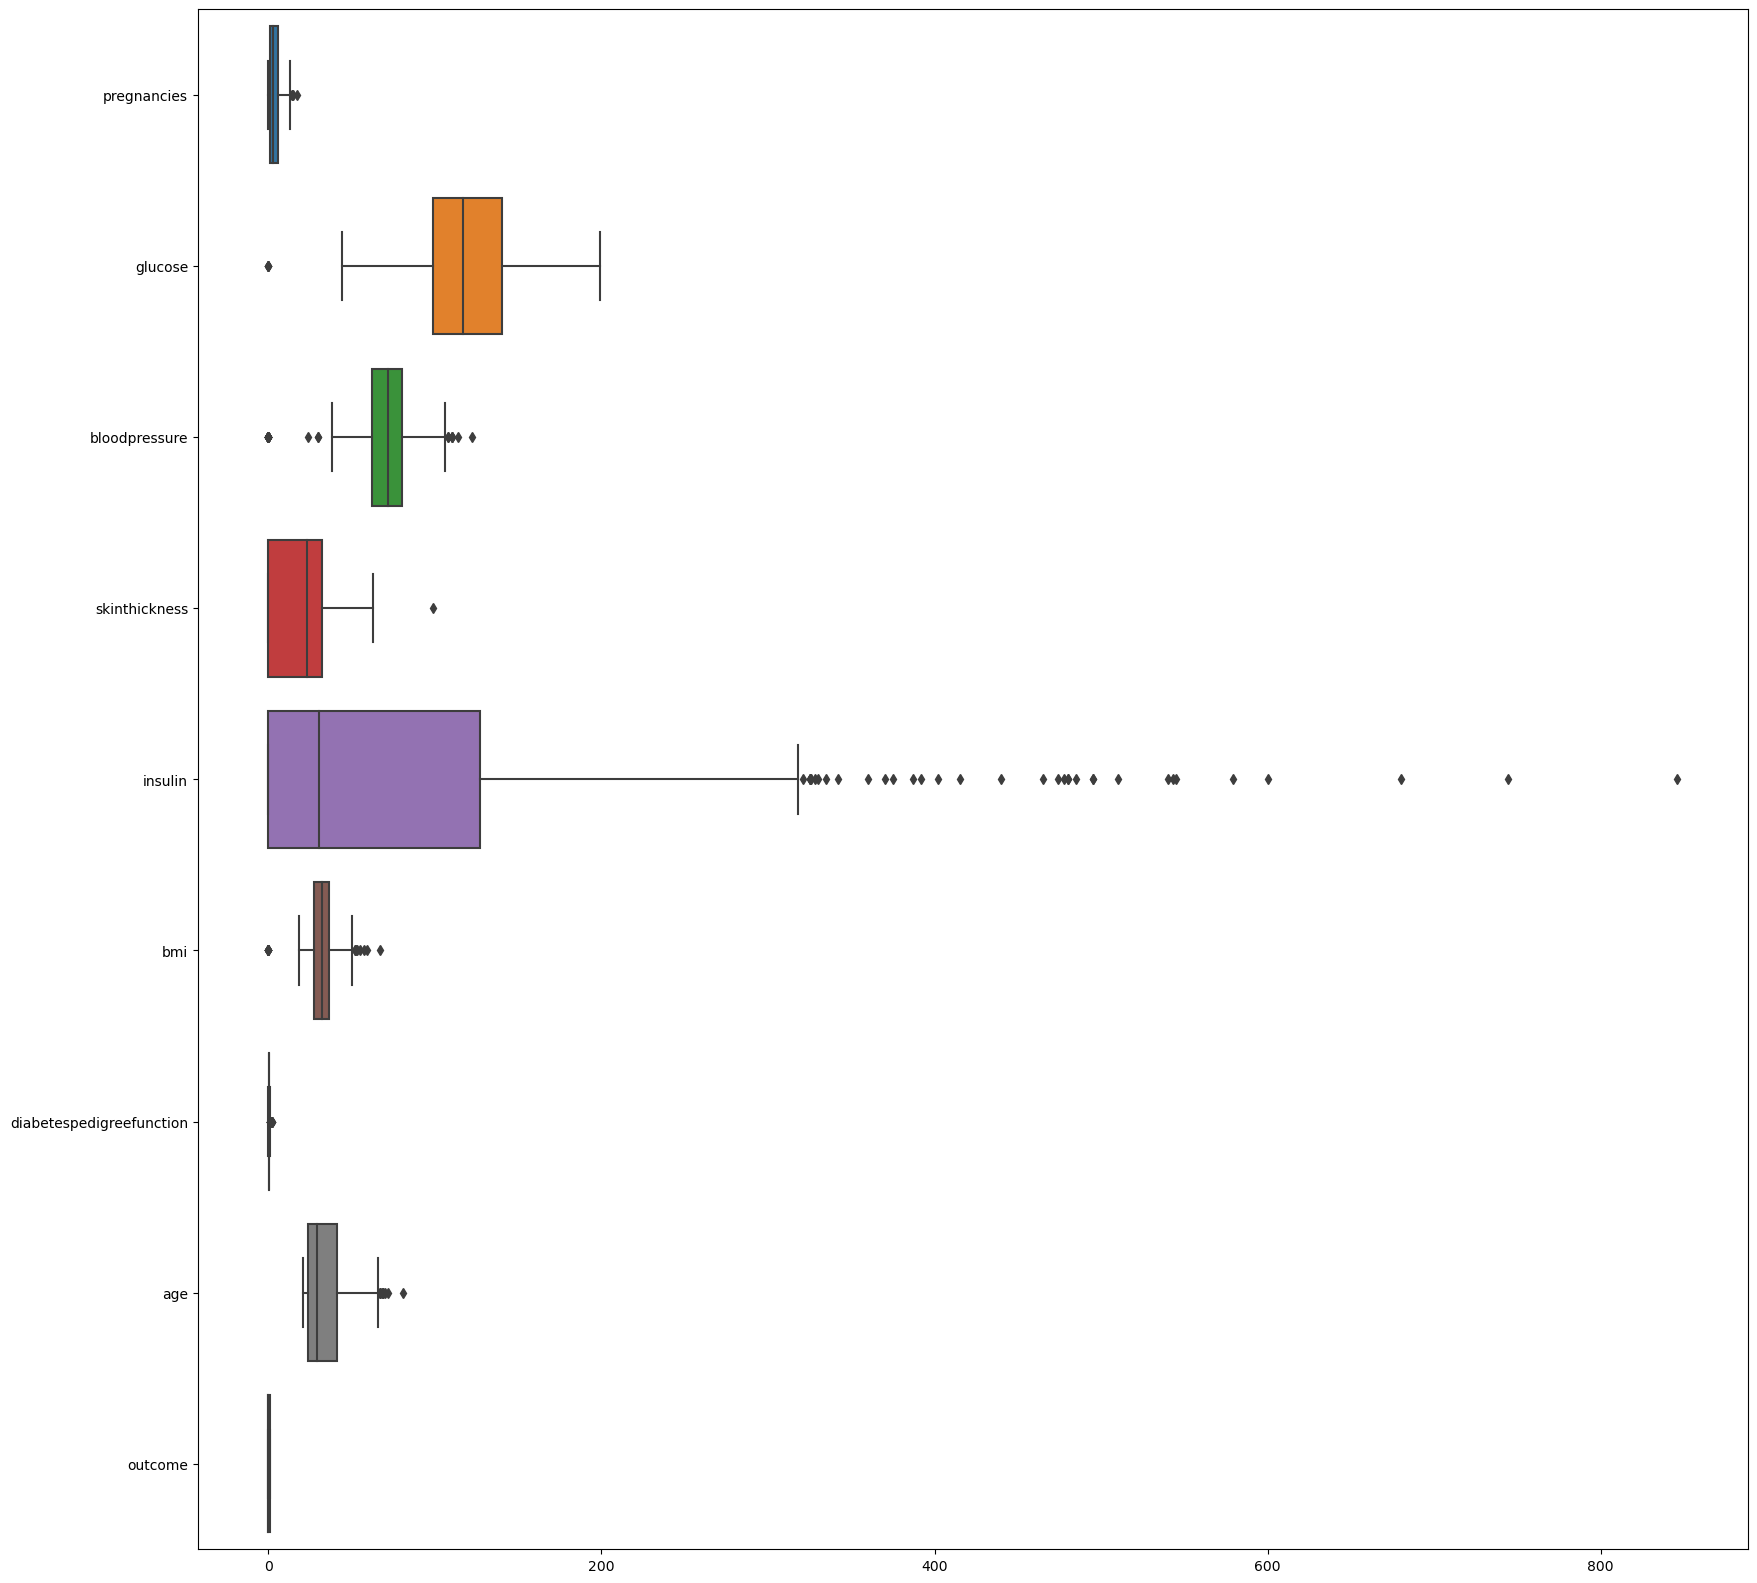

In [6]:
# Checking Outliers

f, ax = plt.subplots(figsize=(20,20))
fig = sns.boxplot(data=df, orient="h")


<AxesSubplot:>

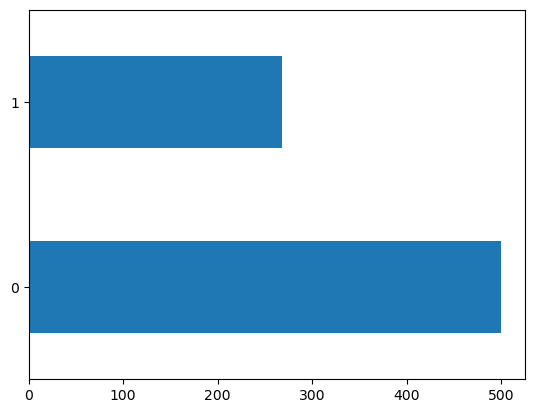

In [7]:
df["outcome"].value_counts().plot.barh()

<AxesSubplot:>

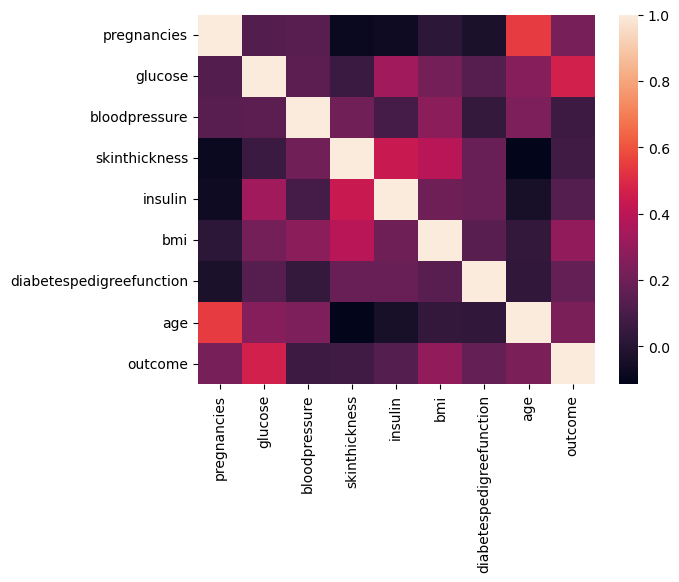

In [8]:
# let's see the corr graphs of the variables
corr = df.corr()

sns.heatmap(corr,
         xticklabels=corr.columns,
         yticklabels=corr.columns)

In [9]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

   Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
   Note Categorical variables include categorical variables with numeric appearance.

    Parameters
    ------
        dataframe: dataframe
                Dataframe to get variable names
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical view

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        
        The sum of 3 lists with return equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [10]:
# Outliers

def outlier_thresholds(dataframe, col_name, q1=0.15, q3=0.85):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + interquantile_range
    low_limit = quartile1 - 1.3 * interquantile_range
    return low_limit, up_limit
        
        

In [11]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [12]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index
    
    for col in df.columns:
        print(col, grab_outliers(df,col))

In [13]:
def replace_with_thresholds(dataframe, variable):
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in num_cols:
        print(replace_with_thresholds(df, col))

None
None
None
None
None
None
None
None


In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pregnancies,768.000,3.842,3.360,0.000,1.000,3.000,6.000,15.000
glucose,768.000,120.937,31.816,6.500,99.000,117.000,140.250,199.000
bloodpressure,768.000,70.188,15.673,24.200,62.000,72.000,80.000,110.000
skinthickness,768.000,20.504,15.817,0.000,0.000,23.000,32.000,74.000
insulin,768.000,75.132,97.656,0.000,0.000,30.500,127.250,359.800
bmi,768.000,32.047,7.454,5.968,27.300,32.000,36.600,53.785
diabetespedigreefunction,768.000,0.463,0.296,0.078,0.244,0.372,0.626,1.321
age,768.000,33.224,11.700,21.000,24.000,29.000,41.000,70.000
outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [15]:
# There are no missing observations in the dataset
# but for variables such as Glucose, Insulin, etc., observation units containing a value of 0 may represent a missing value.

variables = ["skinthickness", "insulin"]
df[variables] = df[variables].replace(0,np.NaN)
df.isnull().sum()

pregnancies                   0
glucose                       0
bloodpressure                 0
skinthickness               227
insulin                     374
bmi                           0
diabetespedigreefunction      0
age                           0
outcome                       0
dtype: int64

In [16]:
# Handle to missing value
df["skinthickness"].fillna(df.groupby("outcome")["skinthickness"].transform("mean"), inplace=True)
df["insulin"].fillna(df.groupby('outcome')["insulin"].transform("mean"), inplace=True)
df.isnull().sum()

pregnancies                 0
glucose                     0
bloodpressure               0
skinthickness               0
insulin                     0
bmi                         0
diabetespedigreefunction    0
age                         0
outcome                     0
dtype: int64

## Feature Engineering
future engineering is crucial for machine learning because it allows for the development of more advanced and efficient models that can handle larger and more complex datasets.

Machine learning is a rapidly evolving field, and new techniques and algorithms are being developed at an ever-increasing pace. Future engineering is essential for keeping up with these advances, as it involves developing new hardware and software technologies that can support more advanced machine learning models.

Future engineering also involves the development of software frameworks and libraries that can facilitate the development and deployment of machine learning models. For instance, Tensorflow and PyTorch are two widely used frameworks that provide a high-level interface for building and training machine learning models, making it easier for researchers and developers to create and deploy models.

Moreover, future engineering can help address some of the challenges facing machine learning, such as the need for more efficient algorithms and the ethical considerations surrounding AI. By developing new tools and techniques, we can better understand and control the behavior of machine learning models, leading to more reliable and trustworthy systems.

In summary, future engineering is essential for advancing machine learning, and it will play a critical role in shaping the future of AI.

In [17]:
df.loc[(df['age'] >= 21) & (df['age'] <= 50), 'sex_cat'] = 'mature'
df.loc[(df['age'] > 50), 'sex_cat'] = 'elder'

In [18]:
df["new_bmi"] = pd.cut(x=df['bmi'], bins=[0, 18.5, 24.9, 29.9, 35, 40, 100],labels=["underweight", "healthy", "overweight",
                                                                                  "obese1", "obese2", "obese3"])

In [19]:
df.loc[(df["glucose"] < 140), 'glucose_cat'] = "normal"
df.loc[(df["glucose"] >= 140), 'glucose_cat'] = "at_risk"

In [20]:
df.loc[(df['glucose'] < 140) & (df["age"] <= 50), "age_gul_cat"] = "normal_mature"
df.loc[(df['glucose'] < 140) & (df["age"] > 50), "age_gul_cat"] = "normal_elder"
df.loc[(df["glucose"] >= 140)& (df['age'] <= 50), "age_gul_cat"] = "at_risk_mature"
df.loc[(df["glucose"] >= 140)& (df['age'] > 50), "age_gul_cat"] = "at_risk_elder"

In [21]:
df.loc[(df["insulin"] < 126), "insul_level"] = "is_normal"
df.loc[(df["insulin"] >= 126), "insul_level"] = "not_normal"

In [22]:
df.loc[(df["insulin"] < 126) & (df["age"] <= 50), "age_insul_level"] = "is_normal_mature"
df.loc[(df["insulin"] < 126) & (df["age"] > 50), "age_insul_level"] = "is_normal_elder"
df.loc[(df["insulin"] >= 126) & (df["age"] <= 50), "age_insul_level"] = "not_normal_mature"
df.loc[(df["insulin"] >= 126) & (df["age"] > 50), "age_insul_level"] = "not_normal_elder"

In [23]:
df["gulucos_insulin"] = df["glucose"]*df["insulin"]
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome,sex_cat,new_bmi,glucose_cat,age_gul_cat,insul_level,age_insul_level,gulucos_insulin
0,6.000,148.000,72.000,35.000,189.692,33.600,0.627,50.000,1,mature,obese1,at_risk,at_risk_mature,not_normal,not_normal_mature,28074.462
1,1.000,85.000,66.000,29.000,125.155,26.600,0.351,31.000,0,mature,overweight,normal,normal_mature,is_normal,is_normal_mature,10638.201
2,8.000,183.000,64.000,32.861,189.692,23.300,0.672,32.000,1,mature,healthy,at_risk,at_risk_mature,not_normal,not_normal_mature,34713.692
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,mature,overweight,normal,normal_mature,is_normal,is_normal_mature,8366.000
4,0.000,137.000,40.000,35.000,168.000,43.100,1.321,33.000,1,mature,obese3,normal,normal_mature,not_normal,not_normal_mature,23016.000


In [24]:
# Checking again grab_col_names function
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768
Variables: 16
cat_cols: 7
num_cols: 9
cat_but_car: 0
num_but_cat: 2


In [25]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in cat_cols:
    cat_summary(df, col)

        sex_cat  Ratio
mature      687 89.453
elder        81 10.547
##########################################
         glucose_cat  Ratio
normal           571 74.349
at_risk          197 25.651
##########################################
                age_gul_cat  Ratio
normal_mature           529 68.880
at_risk_mature          158 20.573
normal_elder             42  5.469
at_risk_elder            39  5.078
##########################################
            insul_level  Ratio
is_normal           434 56.510
not_normal          334 43.490
##########################################
                   age_insul_level  Ratio
is_normal_mature               397 51.693
not_normal_mature              290 37.760
not_normal_elder                44  5.729
is_normal_elder                 37  4.818
##########################################
   outcome  Ratio
0      500 65.104
1      268 34.896
##########################################
             new_bmi  Ratio
obese1           228 29.688
o

In [26]:
# Encoding

le = LabelEncoder()

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
print(binary_cols)

['sex_cat', 'glucose_cat', 'insul_level']


In [27]:
df = label_encoder(df, "sex_cat")
df = label_encoder(df, 'glucose_cat')
df = label_encoder(df,'insul_level')

In [28]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

ohe_cols = [col for col in df.columns if 12 >= df[col].nunique() > 2]

df = one_hot_encoder(df, ohe_cols, drop_first=True)
df.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome,sex_cat,glucose_cat,insul_level,gulucos_insulin,new_bmi_healthy,new_bmi_overweight,new_bmi_obese1,new_bmi_obese2,new_bmi_obese3,age_gul_cat_at_risk_mature,age_gul_cat_normal_elder,age_gul_cat_normal_mature,age_insul_level_is_normal_mature,age_insul_level_not_normal_elder,age_insul_level_not_normal_mature
0,6.000,148.000,72.000,35.000,189.692,33.600,0.627,50.000,1,1,0,1,28074.462,0,0,1,0,0,1,0,0,0,0,1
1,1.000,85.000,66.000,29.000,125.155,26.600,0.351,31.000,0,1,1,0,10638.201,0,1,0,0,0,0,0,1,1,0,0
2,8.000,183.000,64.000,32.861,189.692,23.300,0.672,32.000,1,1,0,1,34713.692,1,0,0,0,0,1,0,0,0,0,1
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,1,1,0,8366.000,0,1,0,0,0,0,0,1,1,0,0
4,0.000,137.000,40.000,35.000,168.000,43.100,1.321,33.000,1,1,1,1,23016.000,0,0,0,0,1,0,0,1,0,0,1


In [29]:
# Now time to future scaling for numeric cols

rs = RobustScaler()
df[num_cols] = rs.fit_transform(df[num_cols])
df.head()


,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome,sex_cat,glucose_cat,insul_level,gulucos_insulin,new_bmi_healthy,new_bmi_overweight,new_bmi_obese1,new_bmi_obese2,new_bmi_obese3,age_gul_cat_at_risk_mature,age_gul_cat_normal_elder,age_gul_cat_normal_mature,age_insul_level_is_normal_mature,age_insul_level_not_normal_elder,age_insul_level_not_normal_mature
0,0.600,0.752,0.000,0.890,0.946,0.172,0.665,1.235,1,1,0,1,0.969,0,0,1,0,0,1,0,0,0,0,1
1,-0.400,-0.776,-0.333,0.127,0.000,-0.581,-0.056,0.118,0,1,1,0,-0.395,0,1,0,0,0,0,0,1,1,0,0
2,1.000,1.600,-0.444,0.618,0.946,-0.935,0.783,0.176,1,1,0,1,1.489,1,0,0,0,0,1,0,0,0,0,1
3,-0.400,-0.679,-0.333,-0.636,-0.457,-0.419,-0.537,-0.471,0,1,1,0,-0.573,0,1,0,0,0,0,0,1,1,0,0
4,-0.600,0.485,-1.778,0.890,0.628,1.194,2.480,0.235,1,1,1,1,0.574,0,0,0,0,1,0,0,1,0,0,1


## PREDICTION WITH 6 ALGORITHMS

### KNN Model & Prediction

In [30]:

# KNN Model & Prediction


y = df["outcome"]
X = df.drop(["outcome"], axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)

knn_model = KNeighborsClassifier().fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8701298701298701

In [31]:
# Model Tuning
knn_params = {"n_neighbors": np.arange(1,50)}

knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, knn_params, cv=10)
knn_cv.fit(X_train, y_train)



GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [32]:
print("Best params " + str(knn_cv.best_params_))

Best params {'n_neighbors': 7}


In [33]:
knn = KNeighborsClassifier(n_neighbors=7)
knn_tuned = knn.fit(X_train, y_train)
y_pred = knn_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.8701298701298701

### CART Model & Prediction

In [34]:
y = df["outcome"]
X = df.drop(["outcome"], axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)
cart_model = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = cart_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8246753246753247

In [35]:
# Model Tuning
cart = tree.DecisionTreeClassifier(max_depth=6, min_samples_split=10)
cart_tuned = cart.fit(X_train, y_train)
y_pred = cart_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.8376623376623377

I gave random hyperparameters because it can take a long time to get the best hyperparameters, if you want a more accurate result you can try the following codes


In [36]:
# cart_params = {"max_depth": range(1,10),
#                "min_samples_split" : list(range(2,50))}

# cart = tree.DecisionTreeClassifier()
# cart_cv = GridSearchCV(cart, cart_params, cv=10, n_jobs=-1, verbose=2)
# cart_cv_model = cart_cv.fit(X_train, y_train)

# print("Best Params: "+ str(cart_cv_model.best_params_))

### Random Forest Model & Prediction

In [37]:
y = df["outcome"]
X = df.drop(["outcome"], axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)

rf_model = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8571428571428571

In [38]:
# Model Tuning
rf = RandomForestClassifier(max_depth=10, max_features=5, max_leaf_nodes=32, min_samples_split=5, n_estimators=1000)
rf_tuned = rf.fit(X_train, y_train)
y_pred = rf_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.8636363636363636

I gave random hyperparameters because it can take a long time to get the best hyperparameters, if you want a more accurate result you can try the following codes


In [39]:
# rf_params = {"max_depth": [2,5,8,10],
#              "max_features": [2,5,8],
#              "n_estimators": [10,500,1000],
#              "min_samples_split": [2,5,10],
#              "max_leaf_nodes": [4,32,64,128]}

# rf_model = RandomForestClassifier()
# rf_cv_model = GridSearchCV(rf_model, rf_params, cv = 10,  n_jobs = -1, verbose = 2)
# rf_cv_model.fit(X_train, y_train)

# print('Best Params: ' + str(rf_cv_model.best_params_))

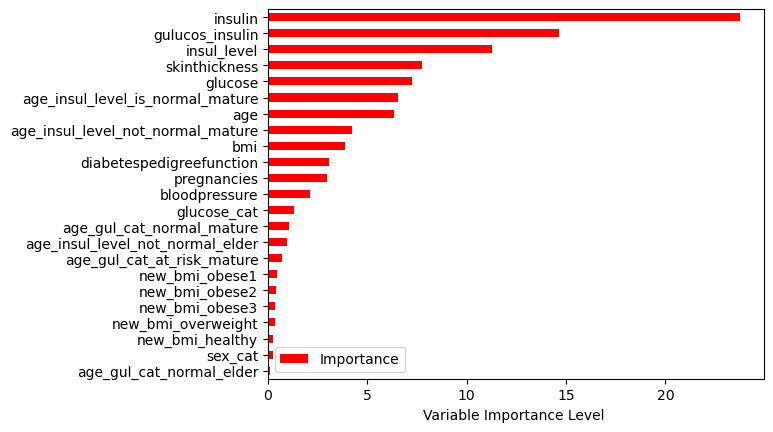

In [40]:
## If you want to see variables importance level
Importance = pd.DataFrame({"Importance": rf_tuned.feature_importances_*100},
                         index = X_train.columns)

Importance.sort_values(by = "Importance",
                       axis = 0,
                       ascending = True).plot(kind ="barh", color = "r")

plt.xlabel("Variable Importance Level ")
plt.show()

### Gradient Boosting Machines


In [41]:
y = df["outcome"]
X = df.drop(["outcome"], axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)

gbm_model = GradientBoostingClassifier().fit(X_train, y_train)
y_pred = gbm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8636363636363636

In [42]:
# Model Tuning
gbm = GradientBoostingClassifier(learning_rate=0.01, max_depth=10, min_samples_split=10,
                                 n_estimators=100, subsample=0.4)


gbm_tuned = gbm.fit(X_train, y_train)
y_pred = gbm_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.8441558441558441

I gave random hyperparameters because it can take a long time to get the best hyperparameters, if you want a more accurate result you can try the following codes


In [43]:
# gbm_params = {"learning_rate" : [0.01, 0.1, 0.05],
#              "n_estimators": [100,500,1000],
#              "max_depth": [3,5,8,10],
#              "min_samples_split": [2,5,10],
#               "subsample": [0.4, 0.6, 0.8]}

# gbm = GradientBoostingClassifier()
# gbm_cv = GridSearchCV(gbm, gbm_params, cv = 10, n_jobs = -1, verbose = 2)
# gbm_cv.fit(X_train, y_train)

# print("Best Params " + str(gbm_cv.best_params_))

### eXtreme Gradient Boosting(XGBoost)

In [44]:
y = df["outcome"]
X = df.drop(["outcome"], axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)

xgbm_model = XGBClassifier().fit(X_train, y_train)
y_pred = xgbm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8441558441558441

In [45]:
# Model Tuning
xgbm = XGBClassifier(learning_rate=0.01, max_depth=10,
                                  n_estimators=500, subsample=0.4)

xgbm_tuned= xgbm.fit(X_train, y_train)
y_pred = xgbm_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.8506493506493507

In [46]:
# xgbm_params = {"learning_rate" : [0.001, 0.01, 0.1, 0.05],
#                "n_estimators": [100,500,800,1000,2000],
#                "max_depth": [3,5,10],
#                "subsample": [0.4, 0.6, 0.8]}

# xgbm = GradientBoostingClassifier()
# xgbm_cv = GridSearchCV(xgbm, xgbm_params, cv = 10, n_jobs = -1, verbose = 2) # 
# xgbm_cv.fit(X_train, y_train)

# print('Best Params: ' + str(xgbm_cv.best_params_))

### Light GBM

In [47]:
y = df["outcome"]
X = df.drop(["outcome"], axis=1)
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=42)

lgbm_model = LGBMClassifier().fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8571428571428571

In [48]:
lgbm = LGBMClassifier(learning_rate=0.01, max_depth=3, subsample=0.6, n_estimators=1000, min_child_samples=10)
lgbm_tuned = lgbm.fit(X_train, y_train)
y_pred = lgbm_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.8701298701298701

In [49]:
# lgbm_params = {"learning_rate" : [ 0.1, 0.01, 0.02, 0.05],
#              "n_estimators": [100,500,1000,2000],
#              "subsample": [0.6, 0.8, 1.0],
#              "max_depth": [3,4,5,10],
#              "min_child_samples": [5,10,20]}

# lgbm = LGBMClassifier()
# lgbm_cv_model = GridSearchCV(lgbm, lgbm_params, cv=10, n_jobs=-1, verbose=2)
# lgbm_cv_model.fit(X_train, y_train)

# print('Best Params: ' + str(lgbm_cv_model.best_params_))

# Comparing All Models

In [50]:
models= [knn_model,cart_model,rf_model,gbm_model,xgbm_model,lgbm_model]
for model in models:
    names = model.__class__.__name__
    y_pred = model.predict(X_test)
    accur = accuracy_score(y_test, y_pred)
    print("-" * 28)
    print(names + ":")
    print("Accuracy: {:.4%}".format(accur))


# Graph
result = []
results = pd.DataFrame(columns=["Models", "Accuracy"])


----------------------------
KNeighborsClassifier:
Accuracy: 87.0130%
----------------------------
DecisionTreeClassifier:
Accuracy: 82.4675%
----------------------------
RandomForestClassifier:
Accuracy: 85.7143%
----------------------------
GradientBoostingClassifier:
Accuracy: 86.3636%
----------------------------
XGBClassifier:
Accuracy: 84.4156%
----------------------------
LGBMClassifier:
Accuracy: 85.7143%


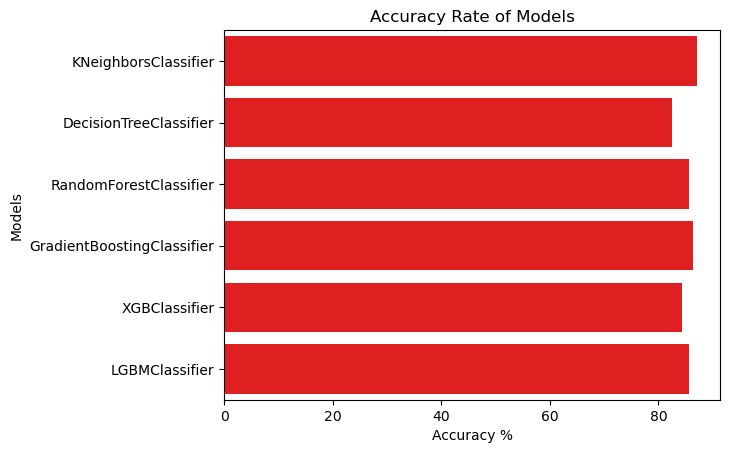

In [51]:
result = []
results = pd.DataFrame(columns=["Models", "Accuracy"])

for model in models:
    names = model.__class__.__name__
    y_pred = model.predict(X_test)
    accur = accuracy_score(y_test, y_pred)
    result = pd.DataFrame([[names, accur * 100]], columns=["Models", "Accuracy"])
    results = results.append(result)
    results.sort_values(by="Accuracy", ascending=False)

results.sort_values(by="Accuracy", ascending=False)

sns.barplot(x='Accuracy', y='Models', data=results, color="r")
plt.xlabel('Accuracy %')
plt.title('Accuracy Rate of Models');

# Comparing Model Tuning Version

In [52]:

models= [knn_tuned,cart_tuned,rf_tuned,gbm_tuned,xgbm_tuned,lgbm_tuned]
for model in models:
    names = model.__class__.__name__
    y_pred = model.predict(X_test)
    accur = accuracy_score(y_test, y_pred)
    print("-" * 28)
    print(names + ":")
    print("Accuracy: {:.4%}".format(accur))


----------------------------
KNeighborsClassifier:
Accuracy: 87.0130%
----------------------------
DecisionTreeClassifier:
Accuracy: 83.7662%
----------------------------
RandomForestClassifier:
Accuracy: 86.3636%
----------------------------
GradientBoostingClassifier:
Accuracy: 84.4156%
----------------------------
XGBClassifier:
Accuracy: 85.0649%
----------------------------
LGBMClassifier:
Accuracy: 87.0130%


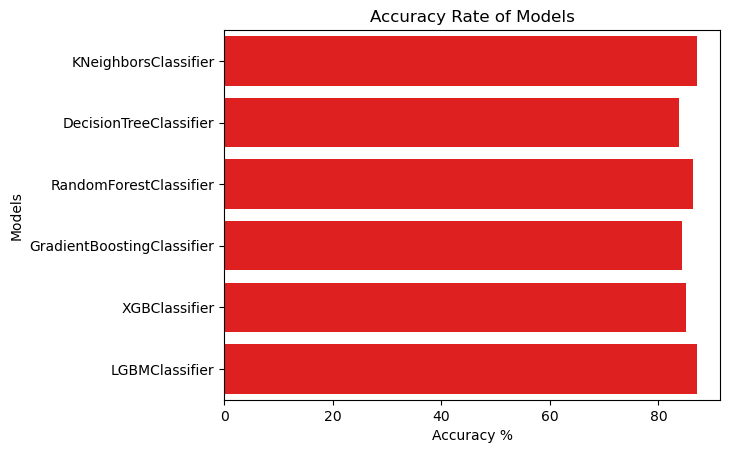

In [53]:
result = []
results = pd.DataFrame(columns=["Models", "Accuracy"])

for model in models:
    names = model.__class__.__name__
    y_pred = model.predict(X_test)
    accur = accuracy_score(y_test, y_pred)
    result = pd.DataFrame([[names, accur * 100]], columns=["Models", "Accuracy"])
    results = results.append(result)
    results.sort_values(by="Accuracy", ascending=False)

results.sort_values(by="Accuracy", ascending=False)

sns.barplot(x='Accuracy', y='Models', data=results, color="r")
plt.xlabel('Accuracy %')
plt.title('Accuracy Rate of Models');


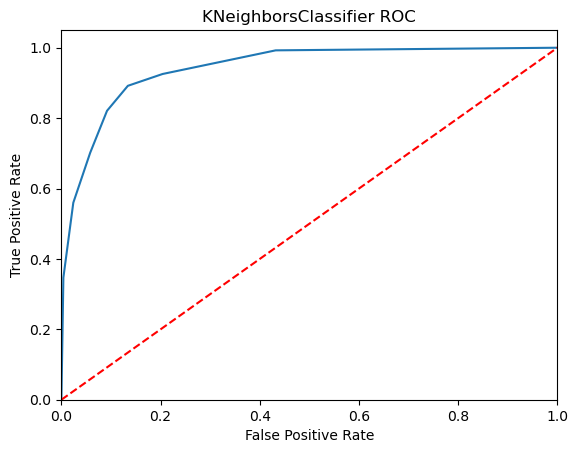

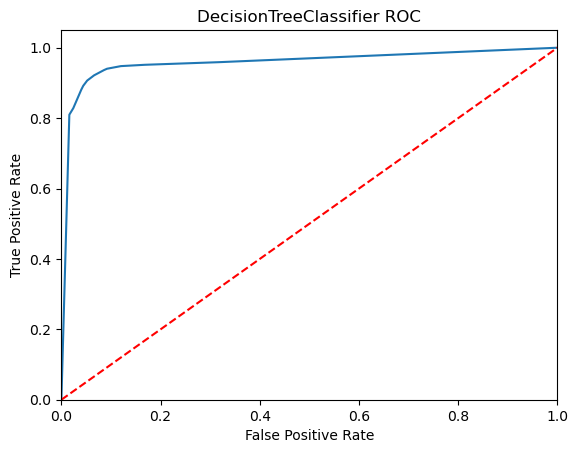

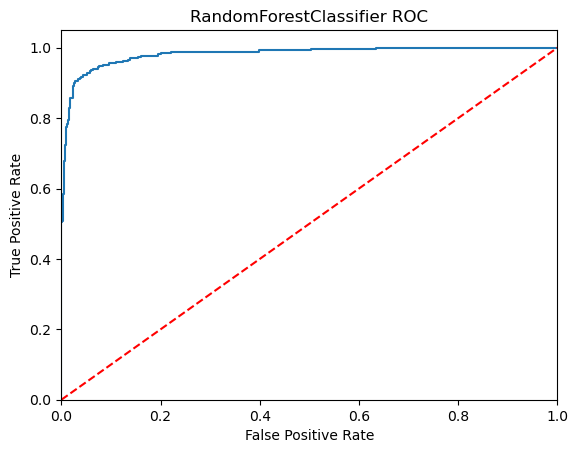

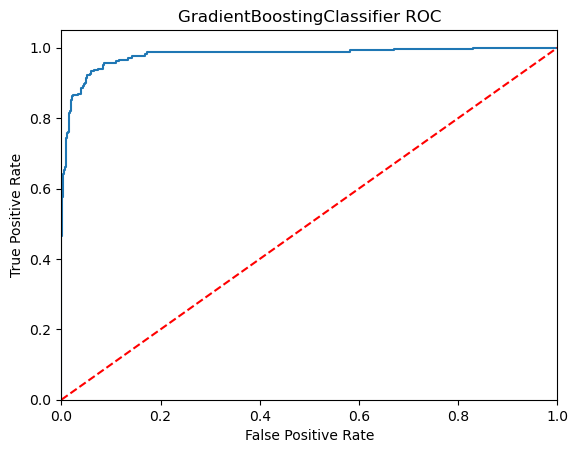

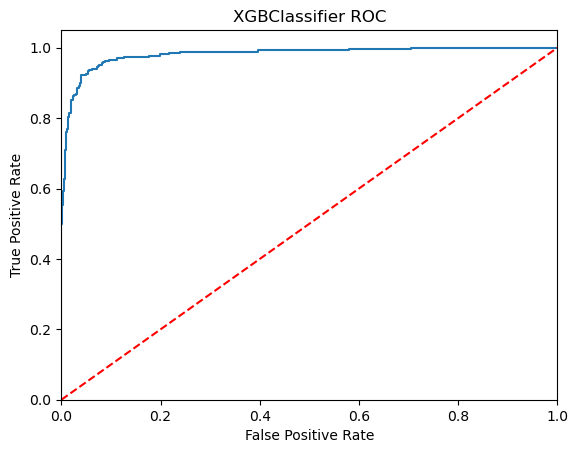

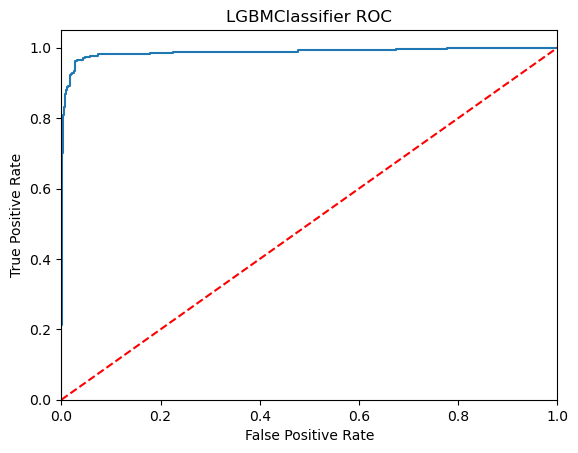

In [54]:
# ROC Graphs

for col in models:
    logit_roc_auc = roc_auc_score(y, col.predict(X))
    names = col.__class__.__name__
    fpr, tpr, thresholds = roc_curve(y, col.predict_proba(X)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label = "AUC (area = %0.2f)" % logit_roc_auc)
    plt.plot([0,1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(names + " ROC")
    plt.show()

# Conclusion

In this Kaggle project, we explored the importance of feature engineering in improving the performance of machine learning models. We began with analyzing the dataset and we analyzed potential features by corr map for creating new and effective features. Using various techniques such as one-hot encoding, scaling, and feature selection, we generated a set of engineered features that were more informative and relevant for our model.

We then trained several machine learning models on the original dataset and compared their performance using various evaluation metric like accuracy(we need to also use precision, recall, and F1-score for better understanding). Our result showed that  feature engineering can significantly improve the accuracy score of machine learning models.

We also experimented with different combinations of features and hyperparameters to find the optimal configuration for our models. By fine-tuning the models and selecting the best features, we were able to achieve a high level of accuracy on the test set, demonstrating the effectiveness of our approach.

In conclusion, feature engineering is a critical step in the machine learning pipeline that can have a significant impact on the performance of models. By carefully selecting and transforming features, we can improve the quality of the input data and enhance the ability of our models to capture complex relationships in the data.

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;">
Thank you for supports and comments.✌️✌🏿
    </br>
You can follow me: </br>
linkedin: <a href="https://www.linkedin.com/in/yunus-emre-turkoglu-89804b193/" target="_blank"><font color=white>Visit My Profile</font></a>

</p>
</div>